In [288]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
import matplotlib.pyplot as plt
%matplotlib inline

### 1 Flow in 2D

In [228]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [229]:
data_x, data_y = sample_data()
data_trn, data_val = data_x[:80000], data_x[80000:]
data_trn_y, data_val_y = data_y[:80000], data_y[80000:]

### 1.1

In [230]:
def build_mlp(layer_in, scope, num_layers, hidden_dim, output_dim, 
              activation=tf.tanh, output_activation=None):
    '''
    layer_out = (None, k)
    '''
    with tf.variable_scope(scope):
        nn = layer_in
        for idx in range(num_layers):
            nn = tf.layers.dense(nn, hidden_dim, activation=activation, 
                                 bias_initializer=tf.contrib.layers.xavier_initializer())
        layer_out = tf.layers.dense(nn, output_dim, activation=output_activation)
    return layer_out

In [231]:
def build_g(layer_in, mask_post, mask_prior, scope, k, num_layers, hidden_dim):
    '''
    layer_in, posterior, prior = (None, 2)
    pi, mu, sigma2 = (None, k)
    '''
    with tf.variable_scope(scope):
        posterior = layer_in * mask_post
        prior = layer_in * mask_prior
        pi = build_mlp(prior, "pi", num_layers, hidden_dim, k, 
                       output_activation=tf.nn.softmax)
        mu = build_mlp(prior, "mu", num_layers, hidden_dim, k)
        sigma2 = build_mlp(prior, "sigma2", num_layers, hidden_dim, k)
        norm_dist = tfp.distributions.Normal(0, 1)
        shifted = tf.expand_dims(posterior, axis=1) - tf.expand_dims(mu, axis=2)
        shifted = tf.reduce_sum(shifted / tf.expand_dims(sigma2, axis=2), axis=-1)
        assert shifted.shape.as_list() == [None, k]
        layer_out = tf.reduce_sum(norm_dist.prob(shifted) * pi, axis=-1, name="layer_out")
        assert layer_out.shape.as_list() == [None]
    return layer_out

$$\log p_{\theta}(x)=\log p\left(f_{\theta}(x)\right)+\log \left|\operatorname{det} \frac{\partial f_{\theta}(x)}{\partial x}\right|$$
$$f_\theta\left(\mathbf{x}_1\right) := \int_{-\infty}^{\mathbf{x}_1} g_\theta\left(\mathbf{t}\right) d\mathbf{t}$$
$$f_\theta\left(\mathbf{x}_2|\mathbf{x}_1\right) := \int_{-\infty}^{\mathbf{x}_2} g_\theta\left(\mathbf{t}|\mathbf{x}_1\right) d\mathbf{t}$$
$$
\frac{\partial \mathbf{z}}{\partial \mathbf{x}}=\left[ \begin{array}{cc}{g_\theta\left(\mathbf{x}_1\right)} & {0} \\ {g_\theta\left(\mathbf{x}_2|\mathbf{x}_1\right)^T\frac{\partial g_\theta\left(\mathbf{x}_2|\mathbf{x}_1\right)}{\partial \mathbf{x}_1}} & {g_\theta\left(\mathbf{x}_2|\mathbf{x}_1\right)}\end{array}\right]
$$
For uniform base distribution, the first term is 0; the second term is 
$$\left|g_\theta\left(\mathbf{x}_1\right)g_\theta\left(\mathbf{x}_2|\mathbf{x}_1\right)\right|$$
To generate samples, 
$$p_{\theta}(\mathbf{x}_1, \mathbf{x}_2) = g_\theta\left(\mathbf{x}_1\right)g_\theta\left(\mathbf{x}_2|\mathbf{x}_1\right)$$

In [265]:
class MixGaussian():
    def __init__(self, sess, k, num_layers=4, hidden_dim=32, learning_rate=5e-4):
        self.sess = sess
        self.input = tf.placeholder(shape=[None, 2], name="input", dtype=tf.float32)
        self.k = k
        
        mask_post_1 = tf.constant([1.0, .0], dtype=tf.float32, name="mask_post_1")
        mask_prior_1 = tf.constant([.0, .0], dtype=tf.float32, name="mask_prior_1")
        self.g_1 = build_g(self.input, mask_post_1, mask_prior_1, "g_1", 
                           k, num_layers, hidden_dim)
        
        mask_post_2 = tf.constant([.0, 1.0], dtype=tf.float32, name="mask_post_2")
        mask_prior_2 = tf.constant([1.0, .0], dtype=tf.float32, name="mask_prior_2")
        self.g_2 = build_g(self.input, mask_post_2, mask_prior_2, "g_2", 
                           k, num_layers, hidden_dim)
        
        self.density_model = tf.abs(self.g_1 * self.g_2)
        self.loss = tf.reduce_mean(-tf.log(self.density_model), axis=0)
        self.op = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
    
    def step(self, batch, with_update=False):
        if with_update:
            loss, _ = self.sess.run([self.loss, self.op], feed_dict={self.input: batch})
        else:
            loss = self.sess.run(self.loss, feed_dict={self.input: batch})
        return loss
    
    def eval_prob(self, samples):
        return self.sess.run(self.density_model, feed_dict={self.input: samples})
    
    def eval_z(self, samples):
        return self.sess.run([self.g_1, self.g_2], feed_dict={self.input: samples})

In [266]:
def plot_density_model(network, step=0.1):
    x, y = np.mgrid[slice(-4, 4, step), slice(-4, 4, step)]
    xv, yv = x.flatten(), y.flatten()
    z = network.eval_prob(list(zip(xv, yv)))
    plt.pcolormesh(x, y, z.reshape(len(x), len(y)))

In [267]:
def train(sess, data_trn, data_val, k=64, batch_size=256, num_epochs=80, 
          log_per_epoch=1, print_per_epoch=10):
    network = MixGaussian(sess, k)
    init_op = tf.initializers.global_variables()
    sess.run(init_op)

    loss_trn = []
    loss_val = []

    for epoch in range(num_epochs):
        loss_trn_batch = []
        for batch in np.array_split(data_trn, np.ceil(len(data_trn)/batch_size)):
            loss = network.step(batch, with_update=True)
            loss_trn_batch.append(loss)

        if epoch % log_per_epoch == 0:
            loss_trn.append(np.mean(loss_trn_batch))
            loss_val.append(network.step(data_val, with_update=False))
        if epoch % print_per_epoch == 0:
            print("at epoch", epoch, loss_trn[-1], loss_val[-1])
    return loss_trn, loss_val, network

In [268]:
tf.reset_default_graph()
sess = tf.Session()
loss_trn, loss_val, network = train(sess, data_trn, data_val)

at epoch 0 2.8927646 1.9513525
at epoch 10 1.8460104 1.8456329
at epoch 20 1.8410031 1.8409194
at epoch 30 1.8393043 1.8392677
at epoch 40 1.8385302 1.838502
at epoch 50 1.8382071 1.8381962
at epoch 60 1.8380548 1.8380513
at epoch 70 1.8379796 1.8379786


### Plots
- loss history
- display samples
- display latents

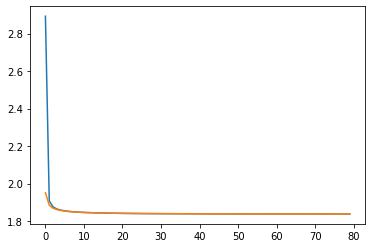

In [269]:
epochs = list(range(0, 80, 1))
plt.plot(epochs, loss_trn)
plt.plot(epochs, loss_val)

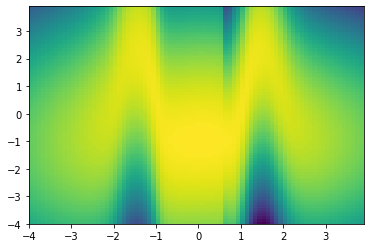

In [270]:
plot_density_model(network)

In [271]:
z_1, z_2 = network.eval_z(data_trn)

(0.3988, 0.399)

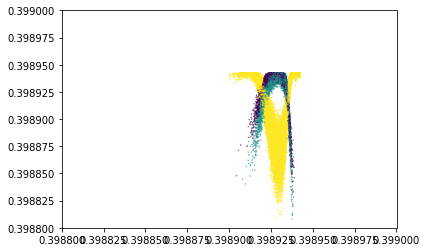

In [285]:
plt.scatter(z_1, z_2, s=0.1, c=data_trn_y)
plt.xlim(0.3988, 0.3990)
plt.ylim(0.3988, 0.3990)

In [ ]:
sess.close()

### 1.2

Within one coupling layer: 
$$
\begin{aligned} y_{1 : d} &=x_{1 : d} \\ y_{d+1 : D} &=x_{d+1 : D} \odot \exp \left(s\left(x_{1 : d}\right)\right)+t\left(x_{1 : d}\right) \end{aligned}
$$
$$
\log \left(p_{X}(x)\right)=\log \left(p_{Z}(f(x))\right)+\log \left(\left|\operatorname{det}\left(\frac{\partial f(x)}{\partial x^{T}}\right)\right|\right) = \log \exp \left[\sum_{j} s\left(x_{1 : d}\right)_{j}\right] = \sum_{j} s\left(x_{1 : d}\right)_{j}
$$

With ```num_layers``` couling layers:
$$
\left(z_{1}, z_{2}\right)=\left(\sigma \circ f_{\theta, 1} \circ \cdots \circ f_{\theta, n}\right)\left(x_{1}, x_{2}\right)
$$

$$
\begin{aligned} z &=f_{k} \circ \cdots \circ f_{1}(x) \\ 
x &=f_{1}^{-1} \circ \cdots \circ f_{k}^{-1}(z) \\ 
\log p_{\theta}(x) 
&=\log p_{\theta}(z)+\sum_{i=1}^{k} \log \left|\operatorname{det} \frac{\partial f_{i}}{\partial f_{i-1}}\right| \\
&=
\end{aligned}
$$

In [289]:
nvp = tfd.TransformedDistribution(
    distribution=tfd.Uniform(low=[0.0, 0.0], high=[1.0, 1.0]), 
    bijector=tfb.RealNVP(
        num_masked=1,
        shift_and_log_scale_fn=tfb.real_nvp_default_template(
            hidden_layers=[512, 512])))

x = nvp.sample()
nvp.log_prob(x)
nvp.log_prob(0.)


ValueError: event_ndims (0) must be larger than min_event_ndims (1)

<tf.Tensor 'real_nvpUniform/sample/real_nvp/forward/concat:0' shape=(2,) dtype=float32>